# Библиотеки

In [31]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from collections import defaultdict
import time

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Функции

In [32]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [33]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [34]:
class ImageClassifier_1(nn.Module):
    def __init__(self, 
                 conv1_dim_1: int, conv1_dim_2: int, conv1_kernel: int, padding_1: int,
                 bn1: int, mp1: int, dp1: int,
                 conv2_dim_1: int, conv2_dim_2: int, conv2_kernel: int, padding_2: int, bn2: int, mp2: int, dp2: int, 
                 fc1_1: int, fc1_2: int, 
                 bn3: int, dp3: int, 
                 fc2_1: int, fc2_2: int
                 ):
        super().__init__()

        model = nn.Sequential()
        model.add_module(
            'conv1', 
            nn.Conv2d(
                conv1_dim_1, conv1_dim_2, 
                kernel_size=conv1_kernel,  
                padding=padding_1
            )
        )

        model.add_module('bn1', nn.BatchNorm2d(bn1))
        model.add_module('relu1', nn.ReLU())
        model.add_module('mp1', nn.MaxPool2d(mp1))
        model.add_module('dp1', nn.Dropout(dp1))

        model.add_module('conv2', nn.Conv2d(conv2_dim_1, conv2_dim_2, kernel_size=conv2_kernel, padding=padding_2))
        model.add_module('bn2', nn.BatchNorm2d(bn2))
        model.add_module('relu2', nn.ReLU())
        model.add_module('mp2', nn.MaxPool2d(mp2))
        model.add_module('dp2', nn.Dropout(dp2))

        model.add_module('flatten', nn.Flatten())
        model.add_module('fc1', nn.Linear(fc1_1, fc1_2))
        model.add_module('bn3', nn.BatchNorm1d(bn3))
        model.add_module('relu3', nn.ReLU())
        model.add_module('dp3', nn.Dropout(dp3))

        model.add_module('fc2', nn.Linear(fc2_1, fc2_2))
        self.model = model

    def forward(self, x):
        return self.model(x)

# Мини ДЗ 14

В 14 Мини ДЗ Вам предстоит самостоятельно сконструировать нейронную сеть и решить задачу классификации рукописных цифр. Можно использовать любую архитектуру и тип нейронных сетей - например полносвязные и/или сверточные.

Использование ноутбука с занятия приветствуется!

Загрузим датасет:

In [35]:
train_dataset = torchvision.datasets.MNIST('.', download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST('.', download=True, train=False, transform=transforms.ToTensor())

In [36]:
train_x, train_y = train_dataset.train_data, train_dataset.train_labels
test_x, test_y = test_dataset.test_data, test_dataset.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [37]:
print('Размер тренировочной выборки:', train_x.shape[0])
print('Размер тестовой выборки:', test_x.shape[0])
print('Размер одного объекта:', test_x.shape[1:])

Размер тренировочной выборки: 60000
Размер тестовой выборки: 10000
Размер одного объекта: torch.Size([28, 28])


Изображения черно-белые, канал 1

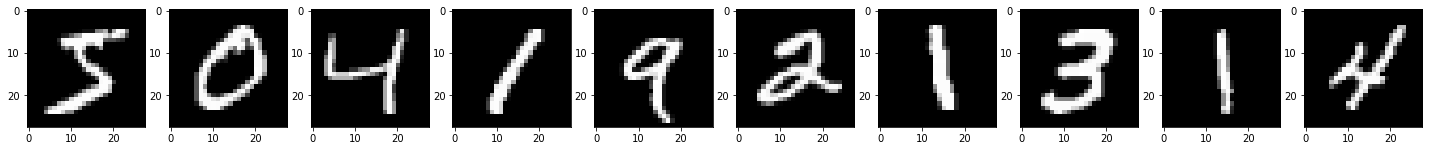

In [38]:
fig, ax = plt.subplots(1, 10, figsize=(25,25))
for i, axis in enumerate(ax):
    axis.imshow(train_x[i], cmap='gray')
plt.show()

Вокруг цифр нет информации, поэтому ```padding``` не нужен


In [39]:
train_y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Классов 10

In [40]:
classes = train_y.unique().detach().numpy().tolist()

In [41]:
class ImageClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, hidden_dim_2: int, num_classes: int):
        super().__init__()
        
        self.model = nn.Sequential(
            # Определите здесь несколько линейных слоев и функций активации

            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, input_batch: torch.Tensor):
        output_batch = self.model(input_batch) # Посчитайте ответы модели
        return output_batch

Теперь нужно определить нужные компоненты для тренировки:

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Модель

In [57]:
# Создайте модель (объект класса ImageClassifier) и поместите её на device
model = ImageClassifier(
    input_dim=(1*28*28), 
    hidden_dim=120, 
    hidden_dim_2=60, 
    num_classes=len(classes)).to(device)

# Определите функционал ошибки для классификации
criterion = nn.CrossEntropyLoss()

# Определите оптимизатор
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

А теперь train loop:

In [44]:
def train_loop(batch_size: int, n_epochs: int, model: ImageClassifier, train_x: torch.Tensor, train_y: torch.Tensor, test_x: torch.Tensor, test_y: torch.Tensor):
    batch_size = batch_size  # Размер батча (столько объектов обрабатываются нейросетью за один forward pass)
    losses = []
    eval_losses = []
    accuracy_list = []
    n_epochs = 20

    for epoch in range(n_epochs):
        model.train()
        current_epoch_train_losses = []
        for i in tqdm(range(0, train_x.shape[0], batch_size), 
                    desc='Training epoch {} from {}'.format(epoch, n_epochs)):
            x_batch = train_x[i: i + batch_size].to(device) # Здесь не забудьте перенести батч с данными на GPU
            y_batch = train_y[i: i + batch_size].to(device) # и здесь тоже

            # print(x_batch.shape)
            x_batch = torch.flatten(x_batch.float(), start_dim=1)
            # print(x_batch.shape)

            # Обнулите градиенты в optimizer
            optimizer.zero_grad()

            # forward pass
            model_output = model(x_batch)

            # посчитайте ошибку по батчу
            loss = criterion(model_output, y_batch.long().to(device))
            
            # Сделайте backward
            loss.backward()

            # Сделайте шаг градиентного спуска
            optimizer.step()

            current_epoch_train_losses.append(loss.item())
        losses.append(np.array(current_epoch_train_losses).mean())
        
        # Evaluation step
        model.eval()
        current_epoch_eval_losses = []
        for i in range(0, test_x.shape[0], batch_size):
            x_batch = test_x[i: i + batch_size].to(device)
            y_batch = test_y[i: i + batch_size].to(device)

            x_batch = torch.flatten(x_batch.float(), start_dim=1)

            with torch.no_grad():
                # Так как на валидации мы не оптимизируем модель, 
                # то нам не нужно считать градиенты. 
                # Поэтому мы воспользовалиь torch.no_grad(). 
                
                # forward pass
                model_output = model(x_batch)

                # посчитайте ошибку по батчу
                loss =  criterion(model_output, y_batch.long().to(device))

            current_epoch_eval_losses.append(loss.item())
        
        correct = (torch.argmax(model_output, dim=1) == y_batch).type(torch.float)
        accuracy_list.append(correct.mean().item())
        
        eval_losses.append(np.array(current_epoch_eval_losses).mean())

    return losses, eval_losses, accuracy_list

In [58]:
losses, eval_losses, accuracy_list = train_loop(64, 20, model, train_x, train_y, test_x, test_y)

Training epoch 0 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 10 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 11 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 12 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 13 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 14 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 15 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 16 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 17 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 18 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 19 from 20:   0%|          | 0/938 [00:00<?, ?it/s]

Нарисуйте графики для train и val лоссов - какие выводы/наблюдения вы можете сделать по ним?

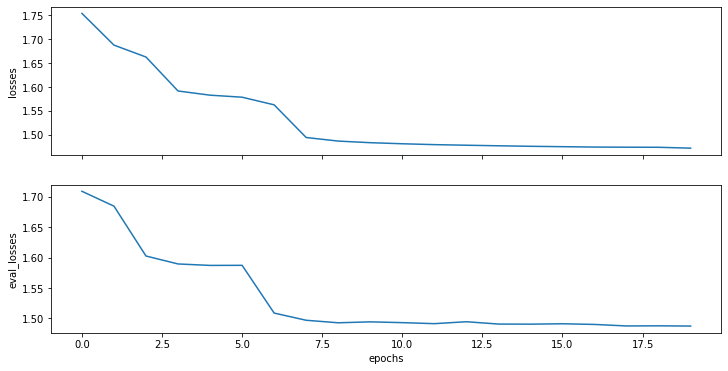

In [59]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(losses)
ax1.set_ylabel("losses")
ax2.plot(eval_losses)
ax2.set_ylabel("eval_losses")
ax2.set_xlabel("epochs")
plt.show()

Посчитайте accuracy полученной модели. 

Постарайтесь получить accuracy 0.9, но начиная с 0.8 можно спокойно сдавать.

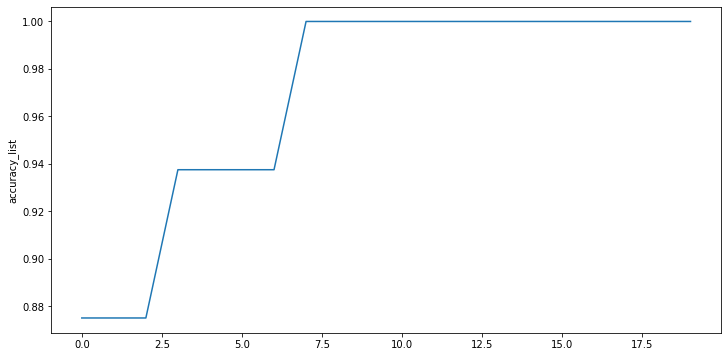

In [60]:
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(accuracy_list)
ax.set_ylabel("accuracy_list")
plt.show()

# Дополнительное задание:

Поэкспериментируйте с разными архитектурами (добавить батч нормализацию и дропаут) и гиперпарамтерами. Как изменилось качество модели? 

In [48]:
dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [50000, 10000]
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [49]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

Попробуем сеть со следующими параметрами:

Epoch 20 of 20 took 9.864s
  training loss (in-iteration): 	0.093617
  validation loss (in-iteration): 	0.077153
  training accuracy: 			97.57 %
  validation accuracy: 			97.77 %


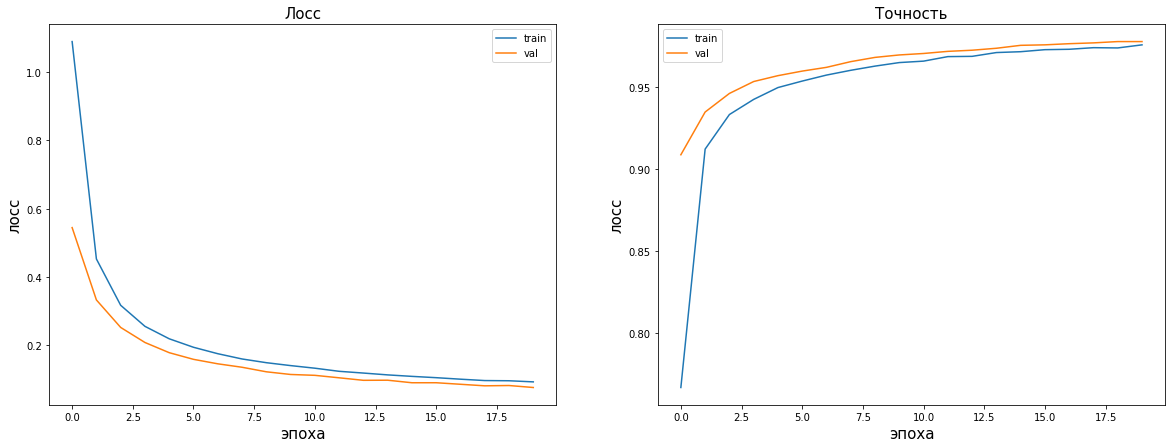

In [50]:
model_1 = ImageClassifier_1(
    conv1_dim_1=1, conv1_dim_2=16, conv1_kernel=5, padding_1=0,
    bn1=16, mp1=2, dp1=0.05,
    conv2_dim_1=16, conv2_dim_2=32, conv2_kernel=3, padding_2=0, bn2=32, mp2=2, dp2=0.05, 
    fc1_1=800, fc1_2=512, 
    bn3=512, dp3=0.02, 
    fc2_1=512, fc2_2=10
).to(device)

optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_1, history = train(
    model_1, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=20
)

Попробуем увеличить количество тренировок:

Epoch 50 of 50 took 10.000s
  training loss (in-iteration): 	0.057948
  validation loss (in-iteration): 	0.052182
  training accuracy: 			98.35 %
  validation accuracy: 			98.49 %


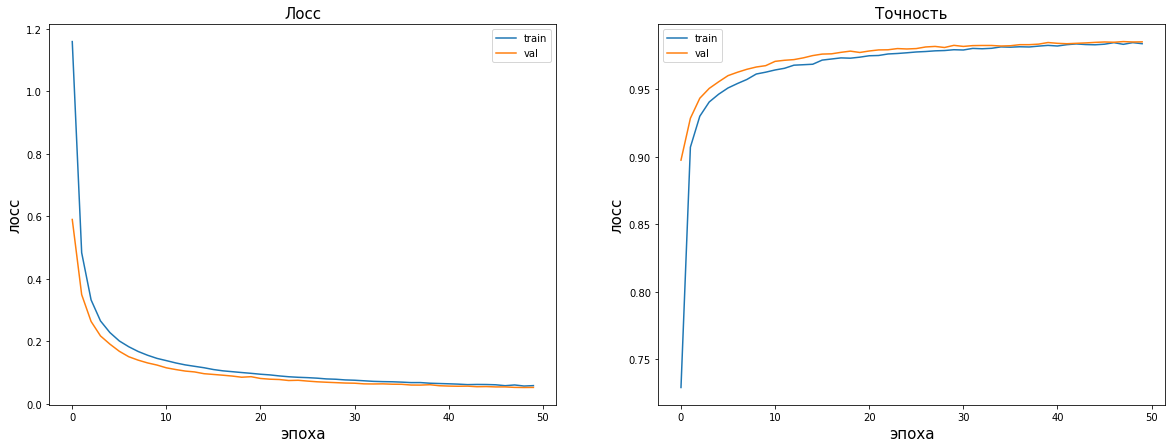

In [51]:
model_1 = ImageClassifier_1(
    conv1_dim_1=1, conv1_dim_2=16, conv1_kernel=5, padding_1=0,
    bn1=16, mp1=2, dp1=0.05,
    conv2_dim_1=16, conv2_dim_2=32, conv2_kernel=3, padding_2=0, bn2=32, mp2=2, dp2=0.05, 
    fc1_1=800, fc1_2=512, 
    bn3=512, dp3=0.02, 
    fc2_1=512, fc2_2=10
).to(device)

optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_1, history = train(
    model_1, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Ошибка уменьшилась, качество улучшилось.

Попробуем изменить параметры сети:

Epoch 50 of 50 took 9.908s
  training loss (in-iteration): 	0.055811
  validation loss (in-iteration): 	0.047753
  training accuracy: 			98.47 %
  validation accuracy: 			98.58 %


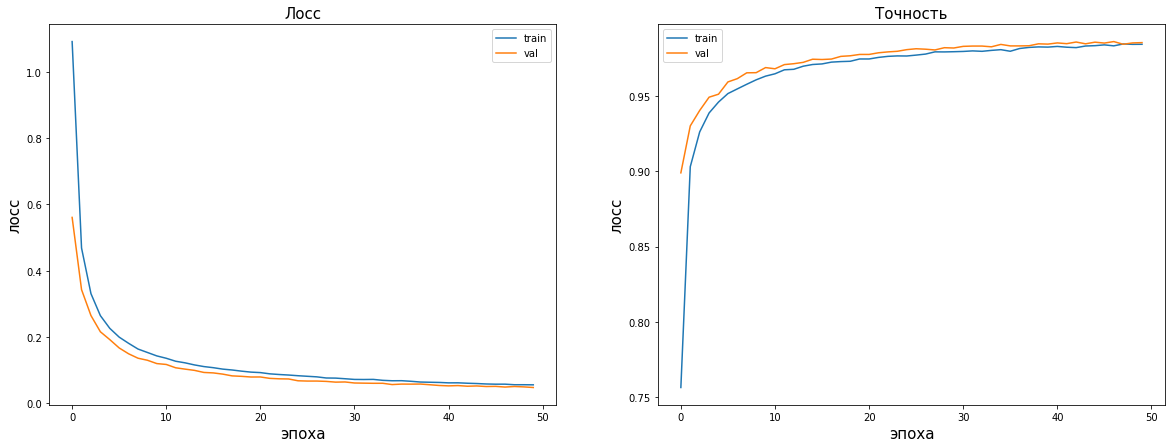

In [52]:
model_2 = ImageClassifier_1(
    conv1_dim_1=1, conv1_dim_2=16, conv1_kernel=5, padding_1=0,
    bn1=16, mp1=2, dp1=0.05,
    conv2_dim_1=16, conv2_dim_2=32, conv2_kernel=3, padding_2=0, bn2=32, mp2=2, dp2=0.05, 
    fc1_1=800, fc1_2=512, 
    bn3=512, dp3=0.05, 
    fc2_1=512, fc2_2=10
).to(device)

optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_2, history = train(
    model_2, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Ошибка и качество изменились незначительно.

Уменьшим дропаут:

Epoch 50 of 50 took 9.925s
  training loss (in-iteration): 	0.087390
  validation loss (in-iteration): 	0.073102
  training accuracy: 			97.80 %
  validation accuracy: 			98.18 %


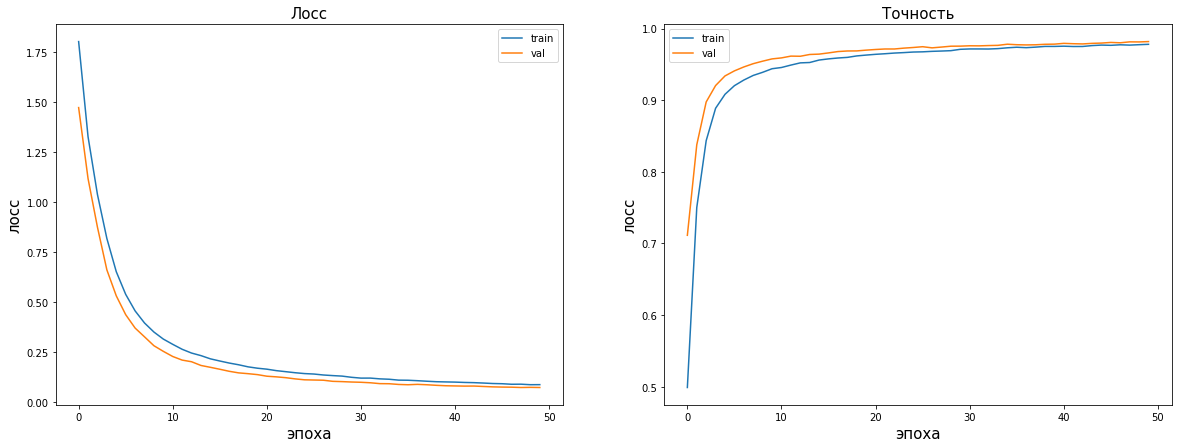

In [53]:
model_3 = ImageClassifier_1(
    conv1_dim_1=1, conv1_dim_2=32, conv1_kernel=8, padding_1=0,
    bn1=32, mp1=4, dp1=0.02,
    conv2_dim_1=32, conv2_dim_2=64, conv2_kernel=3, padding_2=0, bn2=64, mp2=2, dp2=0.02, 
    fc1_1=64, fc1_2=32, 
    bn3=32, dp3=0.02, 
    fc2_1=32, fc2_2=10
).to(device)

optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_3, history = train(
    model_3, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Аналогично, незачительные изменения.

Попробуем без дропаута:

Epoch 50 of 50 took 9.764s
  training loss (in-iteration): 	0.062824
  validation loss (in-iteration): 	0.074830
  training accuracy: 			98.57 %
  validation accuracy: 			98.00 %


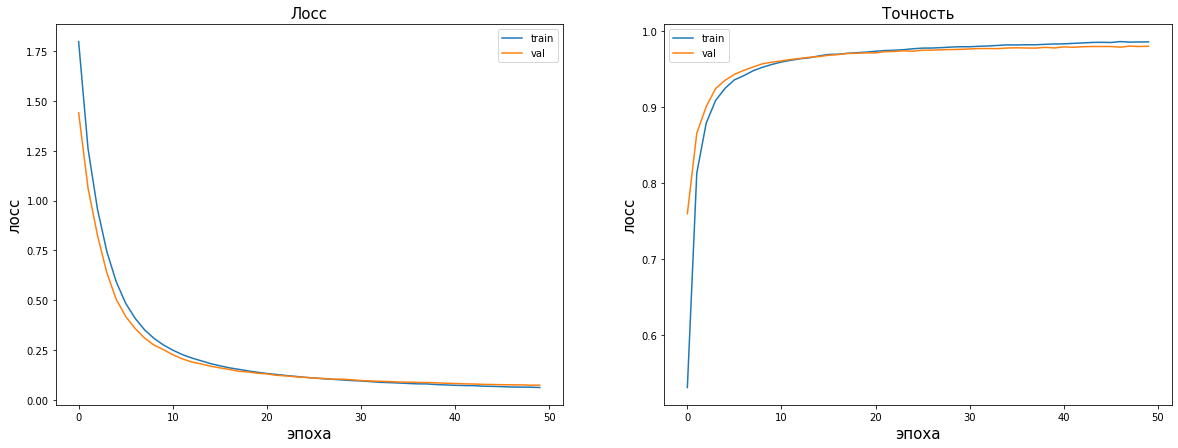

In [54]:
model_4 = ImageClassifier_1(
    conv1_dim_1=1, conv1_dim_2=32, conv1_kernel=8, padding_1=0,
    bn1=32, mp1=4, dp1=0,
    conv2_dim_1=32, conv2_dim_2=64, conv2_kernel=3, padding_2=0, bn2=64, mp2=2, dp2=0, 
    fc1_1=64, fc1_2=32, 
    bn3=32, dp3=0, 
    fc2_1=32, fc2_2=10
).to(device)

optimizer = torch.optim.SGD(model_4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_4, history = train(
    model_4, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Аналогично, незачительные изменения.